In [229]:
import numpy as np
import datetime
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=16)
plt.rcParams['figure.figsize'] = (10.0, 7.0)

In [232]:
def get_spectrum(filename):    
    '''
    DEPRICATED use version in function_definitions
    Get the spectrum of ADC1 in .mpa file. 
    Depends heavily on WHERE in the file it is (i.e. hardcoded line numbers)
    In your text editor, check that: line 159: [DATA0,1024 ]; line 1184: [DATA3,256 ]
    '''
    spec = []
    with open(filename) as f:
        # Loop over lines and keep track of line number
        for i, line in enumerate(f):
            if (i < 159) or (i > 1182):
                continue
            spec.append(int(line))
    # Do some checking
    assert len(spec) == 1024
    if(sum(spec)==0):
        print("Warining: empty spectrum")
    return spec
        

In [233]:
def convert_mpa_time(s):
    '''
    Take a string in the format of mpa file and convert it to something sensible.
    Example string: '; 05/30/2016 16:46:00\n'
    '''
    month = int(s[2:4])
    day = int(s[5:7])
    year = int(s[8:12])
    hour = int(s[13:15])
    minute = int(s[16:18])
    second = int(s[19:21])
    return datetime.datetime(year,month,day,hour,minute,second)

In [234]:
def get_mpa_data(filename):
    '''
    Get the following data from the .mpa file:
      - 
      - 
    '''
    # Initialize dictionary that is to hold all data
    d = {}
    
    with open(filename) as f:
        # Loop over lines and keep track of line number
        # Line number is i + 1
        for i, line in enumerate(f):
            if i == 25:
                d['runtime'] = float(line.split(sep='=')[1])
            if i == 26:
                # Get start timestamp in two ways:
                #  1. timestamp in seconds (x1)
                #  2. timestamp from timestamp string (x2)
                # Throw out 'scrtstart='
                x = line.split(sep='=')[1]
                # Split this into 2 parts
                x1, x2 = x.split(sep = '\t')
                d['start_time_seconds'] = float(x1)
                d['start_datetime'] = convert_mpa_time(x2)
            if i == 77:
                d['livetime'] = float(line.split(sep='=')[1])
            if i == 80:
                d['lc_counts'] = int(line.split(sep='=')[1])
    
    # Derived values
    d['end_datetime'] = d['start_datetime'] + datetime.timedelta(seconds = d['runtime'])
    
    # Sanity cheking
    if (sum(get_spectrum(filename))) != d['lc_counts']:
        raise ValueError("Error: counts from spectrum and total are different!")
    return d
                

In [261]:
def convert_sc_time(s):
    '''
    Take a string in the format of SC program and convert it to something sensible.
    Example string: "b'25.05.2016 13:30:56"
    '''
    # Cut off b' part
    s = s[2:]
    day = int(s[0:2])
    month = int(s[3:5])
    year = int(s[6:10])
    hour = int(s[11:13])
    minute = int(s[14:16])
    second = int(s[17:19])
    return datetime.datetime(year,month,day,hour,minute,second)

def read_sc_data(filename):
    # Load SC data
    dt = np.dtype([('date-time',np.str_,21),
                   ('v', np.float64),
                   ('v_set', np.float64),
                   ('i', np.float64),
                   ('i_set', np.float64),
                   ('temp_basic', np.float64),
                   ('temp_coset', np.float64),
                   ('temp', np.float64),
                  ])
    sc_data = np.loadtxt(filename, dtype=dt, delimiter = ',', skiprows=1, usecols=(0,1,2,4,5,8,9,10))
    
    # Convert the STRING date-time to a datetime.datetime timestamp
    t = np.array([convert_sc_time(datetime) for datetime in sc_data['date-time'] ])
    
    return t, sc_data

def get_correction_factor(t, sc_data, start_datetime, end_datetime, verbose=True, plot=False):
    '''
    Get the correction factor based on voltage and current readings.
    filename: SC file name
    '''
    
    # Get a mask within time range
    time_mask = (t > start_datetime) & (t < end_datetime)
    dead = (t > start_datetime) & (t < end_datetime) & (sc_data['i'] < 0.4)
    mask = (t > start_datetime) & (t < end_datetime) & (sc_data['i'] >= 0.4)
    
    v_power = 3.5
    i_power = 1.
    
    v_eff = (np.average(sc_data[mask]['v']**v_power))**(1/v_power)
    i_eff = (np.average(sc_data[mask]['i']**i_power))**(1/i_power)
    t_dead = len(t[dead])
    
    if verbose:
        print("v_eff: %f" % v_eff)
        print("v_avg: %f" % np.average(sc_data[mask]['v']))
        print("v_std: %f" % np.std(sc_data[mask]['v']))
        print("")
        print("i_eff: %f" % i_eff)
        print("i_avg: %f" % np.average(sc_data[mask]['i']))
        print("i_std: %f" % np.std(sc_data[mask]['i']))    
        print("")
        print("deadtime: %d" % t_dead)
    
    if plot:
        plt.plot(t[time_mask],sc_data[time_mask]['v'], label='voltage', color='blue')
        if len(t[dead]) > 0:
            plt.scatter(t[dead],sc_data[dead]['v'], label='voltage', color='red')

        plt.axhline(v_eff,ls='--', lw=1.5, color='blue', label = 'v_eff')
        plt.ylabel('Voltage (kV)')
        plt.ylim(0,60)
        
        
        
        plt.twinx()
        plt.plot(t[time_mask],sc_data[time_mask]['i'], label='current', color='green')
        plt.axhline(i_eff,ls='--', lw=1.5, color='green', label = 'i_eff')
        if len(t[dead]) > 0:
            plt.scatter(t[dead],sc_data[dead]['i'], label='deadtime', color='red')
        plt.ylabel('Current (mA)')
        plt.ylim(0,2.5)
        
        plt.legend(loc='lower right')
        plt.gcf().autofmt_xdate()
        plt.show()
        
    return v_eff, i_eff, t_dead
    

In [ ]:
sc_filename = 'PTB_DATA/Run02_160527.txt'
t, sc_data = read_sc_data(sc_filename)

In [258]:
filenames = ['./PTB_DATA/2016_MAY_30/2016_MAY_30_2_5MeV_LC1_BG_1.MPA',
            './PTB_DATA/2016_MAY_30/2016_MAY_30_2_5MeV_LC1_FG_1.MPA',
            './PTB_DATA/2016_MAY_30/2016_MAY_30_2_5MeV_LC1_FG_2.MPA',
            './PTB_DATA/2016_MAY_30/2016_MAY_30_2_5MeV_LC1_FG_3.MPA']

filename = filenames[0]

v_eff: 57.407467
v_avg: 57.401559
v_std: 0.527120

i_eff: 2.188757
i_avg: 2.188757
i_std: 0.025964

deadtime: 196


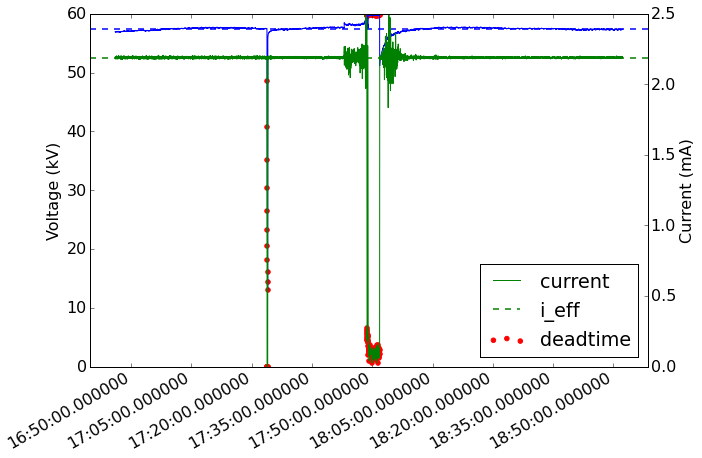

(57.407467043372073, 2.1887565184984412)

In [259]:
d = get_mpa_data(filename)
get_correction_factor(t,sc_data,d['start_datetime'],d['end_datetime'],plot=True)

v_eff: 57.407467
v_avg: 57.401559
v_std: 0.527120

i_eff: 2.188757
i_avg: 2.188757
i_std: 0.025964

deadtime: 196


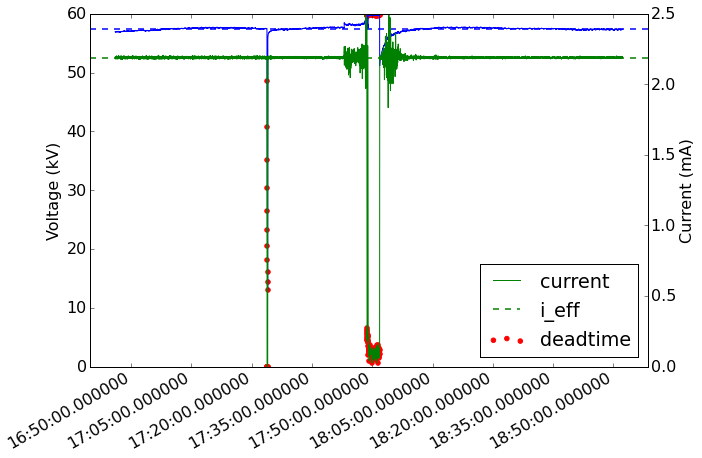

v_eff: 56.647314
v_avg: 56.640252
v_std: 0.567548

i_eff: 2.188430
i_avg: 2.188430
i_std: 0.012243

deadtime: 54


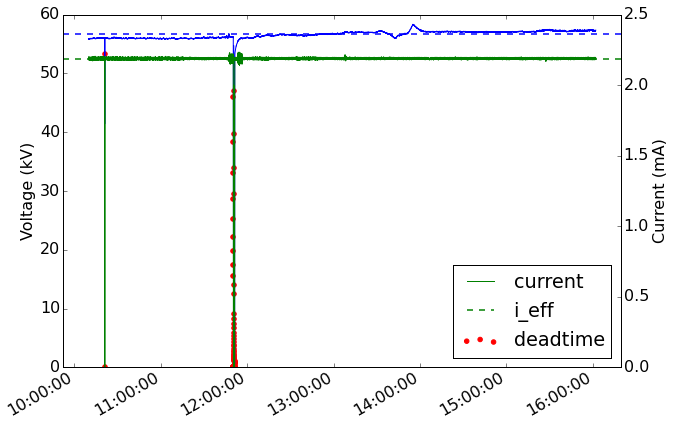

v_eff: 57.474307
v_avg: 57.473232
v_std: 0.222688

i_eff: 2.189018
i_avg: 2.189018
i_std: 0.004225

deadtime: 0


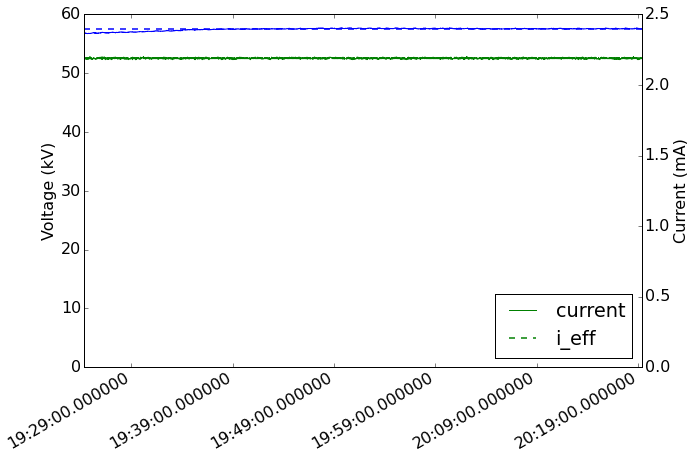

v_eff: 53.404655
v_avg: 53.403790
v_std: 0.191942

i_eff: 0.992266
i_avg: 0.992266
i_std: 0.002513

deadtime: 0


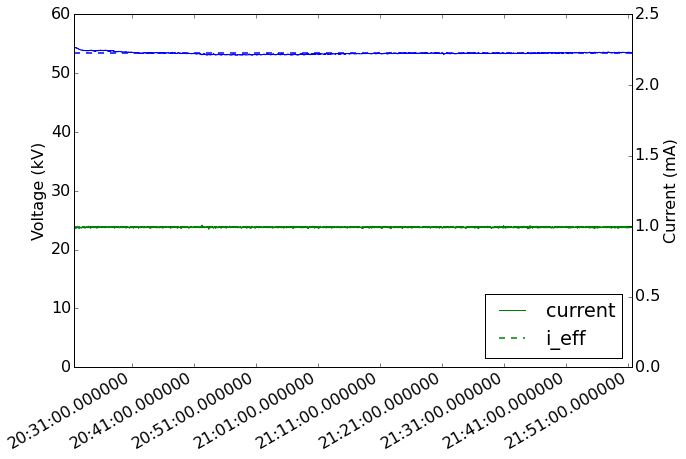

In [262]:
for filename in filenames:
    d = get_mpa_data(filename)
    get_correction_factor(t,sc_data,d['start_datetime'],d['end_datetime'],plot=True)

In [146]:
spec = get_spectrum(filename)

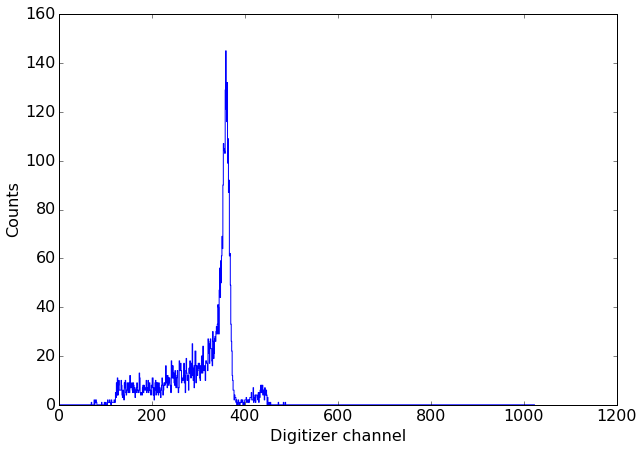

In [38]:
plt.plot(spec,linestyle='steps')
plt.xlabel('Digitizer channel')
plt.ylabel('Counts')
plt.show()

In [39]:
sum(spec)

5066